In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import os

from IPython.display import HTML
from IPython.display import display_html

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from utils.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* "Microsoft.WebBrowser.Protobuf.UMA.Histograms\\"
    * shows up both in continuous and discrete queries; is this a special type of data-structure?
    
* Questions
    * 'attribute': {'name': 'Confidence:3', 'dataType': 'Double'}, 'values': ['0.5D'], 'children': [], 'isSorted': True} ----> why are column names of the type col_name:%d
    * example when PartitioningColumn not in inputColumns:
        device_id v/s DeviceID
        others?
    * sometimes filter input column something like: partialRowNum0


* TODO: combine this with join tables data; Probably can't draw a lot of conclusion about partitioning etc. w/o considering the join workload

* NormInput vs HashTagInput
* inputSelected vs inputColumns
* #FilterColumns vs #FilterColumnsPerSQL. FilterColumns separate plot;
    * #FilterColumns total used for input
    * #Mean, max/min/std filter columns per job per input
* PartitioningColumn Questions:
    * PartitionColumns vs FilterColumns; How often are these the same??
    * #PartitioningColumn
    * Sanity Check: for an input, the #PartitioningColumn (std) == 0??
    * when are partitionin columns === nan / 0; how often / why? does this mean rr partitioning, or something else?
    * only one column is DESC, 550 are ASC!
* Whats up w/ the outlier inputs, e.g., one with inputColumns std peaking at 100??

* Operator questions
    * What kind of operators? distribution for each kind.
    * how often are there multiple filters on SAME column;
    * mixed operators; pairwise distributions; e.g., range + = operators are very rare
    * QUESTION: don't see ANY like operator?????
    
* VertexCount; what does this signify? how often does this change across inputs?

In [203]:
# FN = "combined-0J-2021-05-22.ss.csv"
# INP_FIELD = "NormInput"
# DEDUP_FIELDS = [INP_FIELD, FILTER_FIELD]

FN = "../data/cosmos08/raw_views_filters_2021-12-15.ss.csv"
DEDUPFN = FN.replace(".ss.csv", "-dedup.ss.csv")
INP_FIELD = "NormInputHashCode"
FILTER_FIELD = "FilterExpr"
DEDUP_FIELDS = [INP_FIELD, FILTER_FIELD]

STATCOLS = ["like_ops", "discrete_ops", "cont_ops"]
#STATSTODROP = ["std", "min", "max", "25%", "50%","75%"]
#INP_FIELD = "HashTagInput"

In [204]:
#df = pd.read_csv(FN, sep="|")
#df = pd.read_csv(FN, sep="\t")
#df = pd.read_csv(DEDUPFN, sep="\t")
if os.path.exists(DEDUPFN):
    df = pd.read_csv(DEDUPFN, sep="\t")
else:
    df = pd.read_csv(FN, sep="\t")

In [205]:
#df = df.rename(columns={"#Field:JobGUID":"jobid"})
df = df.rename(columns={"JobGUID":"jobid"})

In [206]:
df.keys()

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'num_ops', 'num_unique_ops', 'unique_filter_cols', 'like_ops',
       'like_lens', 'like_dtype', 'like_kind', 'like_casting', 'like_const',
       'discrete_ops', 'discrete_eqs', 'discrete_noneqs', 'discrete_type',
       'discrete_types_all', 'null_checks', 'cont_ops', 'cont_dates',
       'cont_others', 'cont_type', 'cont_dtype', 'cont_range', 'cont_cols',
       'types_all', 'complex_ops', 'complex_ops_num', 'udf_ops', 'in_ops',
       'equal_dates', 'num_discrete_consts'],
      dtype='object')

# Duplicate and then execute ---> we could group these together, but probably won't make a big difference in the stats we collect

In [207]:
print(len(set(df[INP_FIELD])))

14554


In [208]:
print(len(df))

3087770


In [209]:
# df.groupby(["inputColumns"])["NormInput"].nunique().reset_index().sort_values(\
#     by="NormInput", ascending=False).reset_index().describe(percentiles=[0.9,0.99])

In [210]:
# df.groupby(["inputColumns","InputCardinality"])["NormInput"].nunique().reset_index()

In [211]:
def pretty_print(df):
    return display( HTML( df.to_html(index=False).replace("\\n","<br>") ) )

In [212]:
pretty_print(df.groupby([INP_FIELD, FILTER_FIELD])["jobid"].count().reset_index().sort_values(by="jobid", 
                                    ascending=False)["jobid"].describe(percentiles=[0.9,0.99]).\
                                    reset_index().\
            rename(columns={"jobid":"Input, FilterExprNorm \\n Duplicates"}))

index,"Input, FilterExprNorm Duplicates"
count,3087770.0
mean,1.0
std,0.0
min,1.0
50%,1.0
90%,1.0
99%,1.0
max,1.0


In [88]:
df = df.drop_duplicates(DEDUP_FIELDS)

In [235]:
if not os.path.exists(DEDUPFN):
    df.to_csv(DEDUPFN, sep="\t", index=False)

NameError: name 'os' is not defined

In [214]:
#df2 = pd.read_csv(DEDUPFN)

In [215]:
#print(df2.keys())
print(df.keys())

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'num_ops', 'num_unique_ops', 'unique_filter_cols', 'like_ops',
       'like_lens', 'like_dtype', 'like_kind', 'like_casting', 'like_const',
       'discrete_ops', 'discrete_eqs', 'discrete_noneqs', 'discrete_type',
       'discrete_types_all', 'null_checks', 'cont_ops', 'cont_dates',
       'cont_others', 'cont_type', 'cont_dtype', 'cont_range', 'cont_cols',
       'types_all', 'complex_ops', 'complex_ops_num', 'udf_ops', 'in_ops',
       'equal_dates', 'num_discrete_consts'],
      dtype='object')


In [216]:
def qerr(val1, val2):
    val1 = max(1, val1)
    val2 = max(1, val2)
    q = max (float(val1)/val2, float(val2)/val1)
    return q

In [217]:
df["InputCardinality"] = df.apply(lambda x: max(1, x["InputCardinality"]), axis=1)
df["Selectivity"] = df.apply(lambda x: min(float(x["RowCount"])/x["InputCardinality"], 1.0) ,axis=1)

In [218]:
df["QError"] = df.apply(lambda x:  qerr(x["RowCount"], x["EstCardinality"]),axis=1)

In [219]:
HTML(df["Selectivity"].describe(percentiles=[0.75, 0.9, 0.99]).reset_index().to_html(index=False))

index,Selectivity
count,3.087770e+06
mean,1.724656e-01
std,3.298771e-01
min,0.000000e+00
50%,2.192675e-03
75%,1.197572e-01
90%,9.952066e-01
99%,1.000000e+00
max,1.000000e+00


In [220]:
#HTML(df["QError"].describe(percentiles=[0.75, 0.9, 0.99]).reset_index().to_html(index=False))

In [221]:
#HTML(df["RowCount"].describe(percentiles=[0.75, 0.9, 0.99]).reset_index().to_html(index=False))

In [222]:
#df.groupby(["exploratory_job"])["ExclusiveTime"].describe()

# Amount of time spent in filters vs whole jobs

In [223]:
#HTML(df[["ExclusiveTime", "InclusiveTime"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [224]:
#df = df[df.InclusiveTime >= 2.506925e+02]

In [225]:
#print(set(cont_ranges))

In [226]:
# df2 = df.sample(frac=0.01)
# parse_filter_exprs(df2, INP_FIELD, FILTER_FIELD)

In [229]:
parse_filter_exprs(df, INP_FIELD, FILTER_FIELD)

******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:2536
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:514
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:2

['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:58212
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:58100
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:3208
{'dtype': 'd

['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:49924
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:49812
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:49700
{'dtype': '

['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:26616
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:18216
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:18104
{'dtype': '

OrderDate:13064
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:34804
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:13176
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.

1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:73910
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(5249425174148947343L /* 2021-12-01T00:32:52.1559439Z */)']]
OrderDate:74358
{'dtype': 'date', 'gt': 1638334800.0, 'comb_op': 'And', 'lt': 1638318772.155943}
-16027.84405708313
1638318772.155943 1638334800.0
******************
******************
['And', '>=', '<=']
[[], ['System.DateTime.FromBinary(637739136000000000L /* 2021-12-01T00:00:00.0000000 */)'], ['System.DateTime.FromBinary(524942517414894734

final num decode errors:  0


In [231]:
#print(len(df[df.num_ops == =1]))
df = df[df["num_ops"] != -1]

In [232]:
#df.to_csv("scope_queries.csv", index=False)

# Like exploration

In [233]:
STATSTODROP = ["std", "min", "max", "99%"]

In [238]:
dflikes = df[df.like_ops == 1]
# dflikes.groupby(["like_dtype"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).drop(columns=STATSTODROP)

In [239]:
STATCOLS = ["ExclusiveTime", "like_lens", "RowCount", "Selectivity"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

#curdrops.append(tuple(["QError","mean"]))
curdrops.append(tuple(["RowCount","mean"]))
curdrops.append(tuple(["Selectivity","mean"]))

pretty_print(dflikes.groupby(["like_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))

In [240]:
pretty_print(dflikes.groupby(["like_kind"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
                  drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))
#      drop(columns=curdrops).\
#      rename(columns={"like_lens":"Filter Length"}).\        
#      round(2))

In [241]:
pretty_print(dflikes.groupby(["like_kind", "like_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={}).\
     drop(columns=curdrops).round(2))

In [242]:
dflikes.groupby("like_const")["jobid"].count().reset_index()["jobid"].describe(percentiles=[0.9,0.99])

count     1264.000000
mean        63.196994
std        991.688180
min          1.000000
50%          1.000000
90%          9.000000
99%        356.800000
max      22597.000000
Name: jobid, dtype: float64

# Summary runtime exploration

In [243]:
STATSTODROP = ["std", "min", "max", "99%"]

In [245]:
# HTML(df.groupby(["cont_ops", "discrete_ops","like_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
# #      reset_index().sort_values(by="count", ascending=False).to_html(index=False))
# df.groupby(["cont_ops", "discrete_ops","like_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).drop(columns=STATSTODROP)

In [439]:
df.groupby(["cont_ops", "discrete_ops","like_ops"])["ExclusiveTime"].sum().reset_index()\
    .sort_values(by="ExclusiveTime", ascending=False)

#df.groupby(["cont_ops"])["ExclusiveTime"].count().reset_index()

,cont_ops,discrete_ops,like_ops,ExclusiveTime
2,0,1,0,3.654136e+08
4,1,0,0,2.889666e+08
6,1,1,0,1.599921e+08
0,0,0,0,3.259435e+07
7,1,1,1,1.595487e+07
5,1,0,1,1.063276e+07
3,0,1,1,6.430750e+06
1,0,0,1,3.844533e+06


In [246]:
#STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount", "exploratory_job", "templated_job"]
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(df.groupby(["cont_ops", "discrete_ops","like_ops"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

In [340]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(df.groupby(["complex_ops","null_checks"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

In [341]:
# STATCOLS = ["unique_filter_cols", "num_cols_all", "num_cols_sel", "num_pcols"]
# curdrops = []
# for si, stc in enumerate(STATCOLS):
#     for sdrop in STATSTODROP:
#         curdrops.append(tuple([stc, sdrop]))
#     if si != 0:
#         curdrops.append(tuple([stc,"count"]))

# #curdrops.append(tuple(["QError","mean"]))
# #curdrops.append(tuple(["VertexCount","mean"]))
# #print(curdrops)
# pretty_print(df.groupby(["cont_ops", "discrete_ops","like_ops"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by=(STATCOLS[0],"count"), ascending=False).\
#      drop(columns=curdrops).\
#      rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE",
#                     "unique_filter_cols":"Num Filter Columns", "num_cols_all":"Total Columns",
#                     "num_cols_sel":"Num Selected Columns", "num_pcols":"Num Partitioning Columns"}).round(2)
#             )

In [342]:
# STATCOLS = ["unique_filter_cols", "num_cols_all", "num_cols_sel", "num_pcols"]
# curdrops = []
# for si, stc in enumerate(STATCOLS):
#     for sdrop in STATSTODROP:
#         curdrops.append(tuple([stc, sdrop]))
#     if si != 0:
#         curdrops.append(tuple([stc,"count"]))

# #curdrops.append(tuple(["QError","mean"]))
# #curdrops.append(tuple(["VertexCount","mean"]))
# #print(curdrops)
# pretty_print(df.groupby(["complex_ops", "null_checks"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by=(STATCOLS[0],"count"), ascending=False).\
#      drop(columns=curdrops).\
#      rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE",
#                     "unique_filter_cols":"Num Filter Columns", "num_cols_all":"Total Columns",
#                     "num_cols_sel":"Num Selected Columns", "num_pcols":"Num Partitioning Columns"}).round(2)
#             )

In [343]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops", "null_checks", 
#                  "complex_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [344]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops", "null_checks", 
#               "complex_ops"])["InclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [345]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops", "null_checks", 
#               "complex_ops"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [346]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops", "null_checks", 
#               "complex_ops"])["QError"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [347]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops", "null_checks", 
#               "complex_ops"])["VertexCount"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [348]:
HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops"])["unique_filter_cols"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

like_ops,cont_ops,discrete_ops,count,mean,std,min,50%,90%,99%,max
0,0,1,1573534.0,1.203993,0.622550,1.0,1.0,2.0,4.0,24.0
0,1,0,1000040.0,1.379808,0.520412,1.0,1.0,2.0,3.0,13.0
0,1,1,403417.0,3.053585,1.218984,1.0,3.0,5.0,7.0,13.0
1,1,0,61810.0,1.998997,0.035963,1.0,2.0,2.0,2.0,3.0
0,0,0,30898.0,1.102466,0.303265,1.0,1.0,2.0,2.0,2.0
1,0,1,9463.0,2.568424,0.905107,1.0,2.0,4.0,5.0,8.0
1,1,1,5527.0,4.023159,1.801949,1.0,5.0,6.0,9.0,9.0
1,0,0,3081.0,1.225901,0.418242,1.0,1.0,2.0,2.0,2.0


In [349]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops", "in_ops", "null_checks", 
#                  "complex_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [350]:
df.keys()

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'num_ops', 'num_unique_ops', 'unique_filter_cols', 'like_ops',
       'like_lens', 'like_dtype', 'like_kind', 'like_casting', 'like_const',
       'discrete_ops', 'discrete_eqs', 'discrete_noneqs', 'discrete_type',
       'discrete_types_all', 'null_checks', 'cont_ops', 'cont_dates',
       'cont_others', 'cont_type', 'cont_dtype', 'cont_range', 'cont_cols',
       'types_all', 'complex_ops', 'complex_ops_num', 'udf_ops', 'in_ops',
       'equal_dates', 'num_discrete_consts'],
      dtype='object')

In [351]:
HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops"])["num_discrete_consts"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

like_ops,cont_ops,discrete_ops,count,mean,std,min,50%,90%,99%,max
0,0,1,1573534.0,1.530505,2.907142,0.0,1.0,2.0,13.0,50.0
0,1,0,1000040.0,0.007904,0.141020,0.0,0.0,0.0,0.0,12.0
0,1,1,403417.0,1.317984,0.525537,0.0,1.0,2.0,2.0,27.0
1,1,0,61810.0,0.000065,0.009852,0.0,0.0,0.0,0.0,2.0
0,0,0,30898.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0,1,9463.0,1.251189,1.812377,0.0,1.0,2.0,4.0,42.0
1,1,1,5527.0,1.026959,0.334683,0.0,1.0,1.0,2.0,2.0
1,0,0,3081.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


# Continuous explorations

In [352]:
dfcont = df[df.cont_ops == 1]

In [353]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfcont.groupby(["cont_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_type":"Continuous Operator \\n Type"}).\
     drop(columns=curdrops).round(2))

In [354]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfcont.groupby(["cont_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_dtype":"Continuous Data \\n Type"}).\
     drop(columns=curdrops).round(2))

In [355]:
# HTML(dfcont.groupby(["cont_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [356]:
# HTML(df.groupby(["cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [357]:
# HTML(dfcont.groupby(["cont_dtype"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [358]:
# HTML(dfcont.groupby(["cont_dtype"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [359]:
# HTML(dfcont.groupby(["cont_dtype", "cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [360]:
# HTML(dfcont.groupby(["cont_dtype"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [361]:
# # HTML(df.groupby(["cont_range"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
# #      reset_index().sort_values(by="count", ascending=False).to_html(index=False))
# #print(set(df["cont_range"]))

# HTML(dfcont.groupby(["cont_dtype"])["cont_range"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [362]:
HTML(dfcont.groupby(["cont_cols"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

cont_cols,count,mean,std,min,50%,90%,99%,max
1,1357815.0,285.495264,6368.697427,0.000,0.0320,21.4710,3427.02532,1840506.672
0,49759.0,1411.027291,17708.342201,0.000,0.6680,102.4574,18467.75458,1632075.988
2,43259.0,388.160353,3002.832766,0.000,7.9800,88.4302,9669.67986,136449.354
3,19778.0,44.958164,219.704933,0.000,0.8165,16.6632,1366.11251,3332.720
4,121.0,12.334793,106.356085,0.000,0.0320,5.1230,31.99640,1170.638
12,30.0,0.025433,0.024916,0.000,0.0300,0.0486,0.09666,0.110
5,27.0,114.034519,182.468576,0.000,5.3100,417.9714,425.05256,426.000
13,2.0,39.787500,0.119501,39.703,39.7875,39.8551,39.87031,39.872
6,1.0,16.400000,NaN,16.400,16.4000,16.4000,16.40000,16.400
7,1.0,0.016000,NaN,0.016,0.0160,0.0160,0.01600,0.016


# Surprising: among range date queries, not so many queries of 1-day to 1-week as you'd expect?

In [363]:
dfr = df[df.cont_range != 0.0]
dfr = dfr[df.cont_dtype == "date"]
dfr["cont_range_days"] = dfr.apply(lambda x: x["cont_range"] / 86400 ,axis=1)

HTML(dfr.groupby(["cont_dtype"])["cont_range_days"].describe(percentiles=[0.25, 0.40,
                            0.6, 0.75, 0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

/tmp/ipykernel_2156990/2504257823.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfr = dfr[df.cont_dtype == "date"]


cont_dtype,count,mean,std,min,25%,40%,50%,60%,75%,90%,99%,max
date,434098.0,5578.685154,140994.196881,-5.0,14.238597,28.0,30.0,30.0,30.041667,92.0,1674.416667,3.652059e+06


# multi-column explorations

In [364]:
# HTML(df.groupby(["discrete_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [365]:
# HTML(df.groupby(["types_all"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [366]:
#df2 = df[df["types_all"].count(",") <= 2]
#df2
types_all = set(df["types_all"].values)
new_types_all = set()
for t in types_all:
    #t2 = t.replace("null,", "")
    if "null" in t:
        continue
    if t.count(",") == 2:
        new_types_all.add(t)

df2 = df[df.types_all.isin(new_types_all)]
# HTML(df2.groupby(["types_all"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).round(2).to_html(index=False))

STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))
curdrops.append(tuple(["QError","mean"]))

pretty_print(df2.groupby(["types_all"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_type":"Continuous Operator \\n Type"}).\
     drop(columns=curdrops).round(2))

In [367]:
# HTML(df.groupby(["types_all"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

# Filter by templated query or not

In [368]:
# import copy
# dfall = copy.deepcopy(df)

In [369]:
#print(df.keys())

In [370]:
# print(len(set(df["HashTagNonStrict"])))
# dftmp = df.groupby("HashTagNonStrict").count()["jobid"].reset_index()
# #print(len(dftmp))
# #print(dftmp.head(5))
# df = dfall
# THRESH = 10
# dftmp1 = dftmp[dftmp["jobid"] <= THRESH]
# dftmp2 = dftmp[dftmp["jobid"] > THRESH]

# repeating_tmps = dftmp2["HashTagNonStrict"].values
# not_repeating_tmps = dftmp1["HashTagNonStrict"].values
# print(len(repeating_tmps), len(not_repeating_tmps))

# import copy

# dfrep = df[df["HashTagNonStrict"].isin(repeating_tmps)]
# dfnonrep = df[df["HashTagNonStrict"].isin(not_repeating_tmps)]

In [371]:
#df = dfall

In [372]:
#HTML(dfrep[["ExclusiveTime", "InclusiveTime"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [373]:
#df.keys()

In [374]:
#HTML(dfnonrep[["ExclusiveTime", "InclusiveTime"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [375]:
HTML(df[["like_ops", "discrete_ops", "cont_ops", "in_ops"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,like_ops,discrete_ops,cont_ops,in_ops
count,3.087770e+06,3.087770e+06,3.087770e+06,3.087770e+06
mean,2.587013e-02,6.451067e-01,4.763289e-01,1.158856e-01
std,1.587478e-01,4.784811e-01,4.994394e-01,3.200877e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
90%,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
99%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [376]:
HTML(df[["like_ops", "discrete_ops", "discrete_eqs", "discrete_noneqs", "in_ops",
         "complex_ops",
         "cont_ops", 
         "cont_dates", "cont_others"]].\
     mean().reset_index().to_html(index=False))

index,0
like_ops,0.025870
discrete_ops,0.645107
discrete_eqs,0.579915
discrete_noneqs,0.112904
in_ops,0.115886
complex_ops,0.024172
cont_ops,0.476329
cont_dates,0.362466
cont_others,0.121893


# More discrete exploration

In [377]:
dfdisc = df[df.discrete_ops == 1]
dfdisc = dfdisc[dfdisc.discrete_type != ""]
# print(len(df), len(dfdisc))
# #HTML(dfdisc.groupby("discrete_type").count()["jobid"].describe(percentiles=[0.9,0.99])\
# #     .reset_index().to_html(index=True))

# HTML(dfdisc.groupby(["discrete_eqs", "discrete_type", "in_ops"]).count()["jobid"].\
#      reset_index().to_html(index=False))

In [379]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfdisc.groupby(["discrete_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"discrete_type":"Discrete Type"}).\
     drop(columns=curdrops).round(2))

In [380]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfdisc.groupby(["discrete_eqs"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"discrete_type":"Discrete Type"}).\
     drop(columns=curdrops).round(2))

In [381]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfdisc.groupby(["like_ops", "discrete_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"discrete_type":"Discrete Type", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

In [382]:
HTML(dfdisc.groupby(["discrete_eqs", "discrete_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

discrete_eqs,discrete_type,count,mean,std,min,50%,90%,99%,max
0,bool,3234.0,0.072348,0.178843,0.0,0.001641,0.086706,1.0,1.0
0,null,119477.0,0.148273,0.279584,0.0,0.020318,0.658830,1.0,1.0
0,num,28602.0,0.544207,0.421020,0.0,0.592843,1.000000,1.0,1.0
0,string,60220.0,0.392939,0.437362,0.0,0.142064,1.000000,1.0,1.0
1,bool,42891.0,0.251192,0.355514,0.0,0.052835,0.999094,1.0,1.0
1,null,26574.0,0.101732,0.218581,0.0,0.011372,0.360900,1.0,1.0
1,num,1123626.0,0.060373,0.227055,0.0,0.000000,0.001807,1.0,1.0
1,string,583609.0,0.196339,0.305854,0.0,0.018685,0.763683,1.0,1.0


### Note: discrete_eq + boolean ----> much higher runtime than any other group;
### Note2: actually, like_ops + bool ----> much higher runtimes

In [383]:
HTML(dfdisc.groupby(["like_ops", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

like_ops,discrete_type,count,mean,std,min,50%,90%,99%,max
0,bool,45747.0,308.461214,7525.934166,0.0,0.6700,15.7900,2141.01094,1150292.797
0,null,143218.0,2567.866356,105641.686080,0.0,0.4660,18.1400,8176.78294,16507412.908
0,num,1150961.0,30.129435,4412.390036,0.0,0.0000,0.0470,106.66800,2352362.122
0,string,633320.0,167.223169,15310.320583,0.0,0.2040,16.7440,1699.70407,10864347.102
1,bool,378.0,652.651320,4251.843885,0.0,0.6665,274.1591,25371.94540,47148.577
1,null,2833.0,1484.539160,30881.957690,0.0,94.7710,160.8170,9146.71312,897449.513
1,num,1267.0,3738.914280,48261.563279,0.0,2.2000,129.6786,3617.49136,657084.297
1,string,10509.0,1255.686712,16272.726470,0.0,0.2980,273.9312,22388.51264,518387.011


In [384]:
HTML(dfdisc.groupby(["like_ops", "cont_ops", "discrete_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

like_ops,cont_ops,discrete_ops,count,mean,std,min,50%,90%,99%,max
0,0,1,1571997.0,230.955256,33447.660859,0.0,0.000,2.8620,143.28608,16507412.908
0,1,1,401249.0,397.255748,5893.043700,0.0,0.439,42.9566,5491.97100,1084407.408
1,0,1,9461.0,679.710923,17964.428158,0.0,0.047,14.1490,3601.27780,657084.297
1,1,1,5526.0,2887.237178,31194.234518,0.0,68.682,1045.0680,37317.65975,897449.513


In [385]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

# Like Ops when discrete_ops = 0

In [386]:
# HTML(dfdisc.groupby(["unique_filter_cols", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

In [387]:
# HTML(dfdisc.groupby(["num_ops", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

# ComplexOps ---> More runtime

In [388]:
HTML(df.groupby(["complex_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

complex_ops,count,mean,std,min,50%,90%,99%,max
0,3013131.0,177.427419,12956.174257,0.0,0.000,9.925,1090.01420,16507412.908
1,74639.0,4678.754027,135683.667726,0.0,0.188,73.767,67029.90468,10864347.102


In [389]:
HTML(df.groupby(["complex_ops"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

complex_ops,count,mean,std,min,50%,90%,99%,max
0,3013131.0,0.175744,0.332556,0.0,0.002317,0.999250,1.0,1.0
1,74639.0,0.040136,0.138729,0.0,0.000101,0.069315,1.0,1.0


# Extreme cases

In [390]:
# dfext = df[df["ExclusiveTime"] == 1546313.691]
# print(dfext.keys())
# print(dfext[FILTER_FIELD].values[0])
# dfext[["OperatorName", "InputCardinality", "VertexCount", "RowCount", "Selectivity", "num_ops", 
#       "num_unique_ops", "unique_filter_cols", "num_cols_all", "num_pcols", "like_ops", 
#       "cont_ops", "cont_dates", "udf_ops"]]

# Top few execution time ones are just String.isNullOrEmpty;
# Next is = true + LIKE predicate

In [391]:
# dftmp = df.sort_values(by="ExclusiveTime", ascending=False)
# NUM=50
# print(dftmp["ExclusiveTime"].head(NUM))
# for i in range(NUM):
#     print(dftmp[FILTER_FIELD].values[i])

In [392]:
df["VertexCount"].describe(percentiles=[0.9, 0.99])

count    3.087770e+06
mean     1.105254e+02
std      5.624390e+02
min      0.000000e+00
50%      4.000000e+00
90%      1.920000e+02
99%      2.002000e+03
max      1.318490e+05
Name: VertexCount, dtype: float64

In [393]:
# corr = df.corr().abs()
# corr["InclusiveTime"].reset_index().sort_values(by="InclusiveTime", ascending=False)\
#     .rename(columns={"InclusiveTime":"Correlation w/ Runtime"})

# Exploring likes

In [394]:
df.groupby("like_ops")["ExclusiveTime"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
like_ops,,,,,,,,
0,3007889.0,281.581756,24942.757258,0.0,0.000,8.907,1105.98756,1.650741e+07
1,79881.0,461.472842,11201.964062,0.0,2.674,503.558,1421.95640,8.974495e+05


In [395]:
#df.groupby("discrete_ops")["ExclusiveTime"].describe(percentiles=[0.9, 0.99])

In [396]:
df.groupby("like_ops")["Selectivity"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
like_ops,,,,,,,,
0,3007889.0,0.173787,0.332992,0.0,0.001410,0.999448,1.000000,1.0
1,79881.0,0.122693,0.168877,0.0,0.033116,0.312776,0.669018,1.0


In [397]:
df.groupby("like_ops")["RowCount"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
like_ops,,,,,,,,
0,3007889.0,2.426472e+08,8.839158e+09,0.0,4767.0,31828366.0,2.760610e+09,2.125475e+12
1,79881.0,7.219953e+07,1.612154e+09,0.0,271686.0,21836831.0,7.687363e+08,1.854638e+11


In [398]:
pretty_print(
    dflikes.groupby("like_ops")[["like_lens"]].describe(percentiles=[0.7, 0.9, 0.99]).\
    reset_index().\
    rename(columns={"like_lens": "Length of like filter", "like_ops":"LIKE"})
)

In [399]:
dflikes = df[df.like_ops == 1]
dflikes = dflikes.sort_values(by="like_lens")
HTML(dflikes.head(20)[["like_lens", FILTER_FIELD, "ExclusiveTime", "Selectivity"]].to_html())

,like_lens,FilterExpr,ExclusiveTime,Selectivity
2493268,0,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""CounterName:3"",""dataType"":""String""},""values"":[""@\""\\XBL PresenceINH users online instance counters\\Online Users\""""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":"""",""dataType"":""Date""},""values"":[""System.DateTime.FromBinary(637740000000000000L /* 2021-12-02T00:00:00.0000000 */)""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""!="",""attribute"":{""name"":"""",""dataType"":""Int""},""values"":[""23""],""children"":[],""isSorted"":false},{""isComparison"":false,""expOperator"":null,""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""Environment.ToLowerInvariant().Contains(\""blulab\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false},{""isComparison"":false,""expOperator"":null,""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""MachineFunction.ToLowerInvariant().EndsWith(\""nu\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false}],""isSorted"":false}",0.124,2.969332e-02
43370,0,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":false,""expOperator"":null,""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""string.IsNullOrWhiteSpace(SigSeqInHex)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":"""",""dataType"":""Bool""},""values"":[""true""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":"""",""dataType"":""Bool""},""values"":[""false""],""children"":[],""isSorted"":false},{""isComparison"":false,""expOperator"":null,""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""string.IsNullOrWhiteSpace(FMS_StaticSignature_State)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false},{""isComparison"":false,""expOperator"":null,""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""string.IsNullOrWhiteSpace(FMS_StaticSignature_ThreatName)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false},{""isComparison"":false,""expOperator"":null,""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""FMS_StaticSignature_ThreatName.EndsWith(\""!plock\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false}],""isSorted"":false}",22.133,4.767575e-06
116513,0,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""StringCaseInsensitiveIn(UserActionName, \""open,like,click,hover\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""StringCaseInsensitiveIn(UserActionName, \""open,click,like,hover\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false}",4.199,1.091458e-06
116489,0,"{""isComparison"":true,""expOperator"":""StringCaseInse

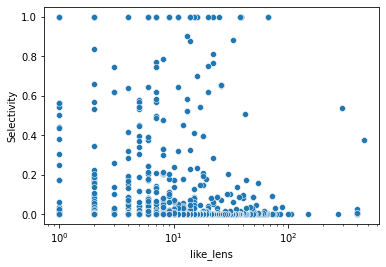

In [400]:
sns.scatterplot(data=dfonlylikes, x="like_lens", y="Selectivity")
plt.xscale("log")
#plt.yscale("log")

(0.0, 1000.0)

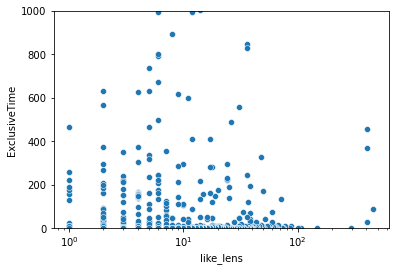

In [401]:
sns.scatterplot(data=dfonlylikes, x="like_lens", y="ExclusiveTime")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0,0.1e4])

In [402]:
#df.groupby("like_ops")["ExclusiveTime"].sum()

In [403]:
dfonlylikes = df[df.like_ops == 1]
dfonlylikes = dfonlylikes[dfonlylikes.discrete_ops == 0]
dfonlylikes = dfonlylikes[dfonlylikes.cont_ops == 0]
dfonlylikes = dfonlylikes[dfonlylikes.complex_ops == 0]
HTML(dfonlylikes.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

In [404]:
dfonlylikes.groupby("like_ops")["like_lens"].describe(percentiles=[0.7, 0.9, 0.99])

,count,mean,std,min,50%,70%,90%,99%,max
like_ops,,,,,,,,,
1,3079.0,15.034102,23.483196,0.0,10.0,21.0,26.0,61.0,459.0


In [405]:
#dfonlylikes = dfonlylikes.sort_values(by="like_lens")
dfonlylikes = dfonlylikes.sort_values(by="like_lens", ascending=False)
HTML(dfonlylikes.head(20)[["like_lens", FILTER_FIELD, "ExclusiveTime", "Selectivity"]].to_html())

,like_lens,FilterExpr,ExclusiveTime,Selectivity
142487,459,"{""isComparison"":true,""expOperator"":""name.StartsWith(\""Microsoft.OSG.DU.DeliveryOptClient.\"") || name.StartsWith(\""Microsoft.Windows.ServiceControlManager.\"") || name.StartsWith(\""Microsoft.Windows.StoreAgent.Telemetry.\"") || name.StartsWith(\""Microsoft.Windows.Update.DataMigrationFramework.\"") || name.StartsWith(\""Microsoft.Windows.Update.Orchestrator.\"") || name.StartsWith(\""Microsoft.Windows.Upfc.\"") || name.StartsWith(\""SIHEngineTelemetry.\"") || name.StartsWith(\""SoftwareUpdateClientTelemetry.\"") || name.StartsWith(\""Update360Telemetry.\"") || name.StartsWitZSrmwsXN5zBEyCq5537vvz9KwFiPUvOFV1D82clyxN4="",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",88.851,3.748887e-01
548448,402,"{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%xbox-game-pass\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/xbox-game-pass/pc-games\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/games/store/game-pass/cfq7ttc0kgq8\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/p/xbox-game-pass-for-pc/cfq7ttc0kgq8\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/p/xbox-game-pass-for-pc-beta/cfq7cZ9jBXLzCijJNsfqt3Zvmh3ylUiOIFSTfZBbmTcZedo="",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",3025.959,5.466265e-03
950832,402,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":false,""expOperator"":null,""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""string.IsNullOrEmpty(anidA)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false},{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%xbox-game-pass\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/xbox-game-pass/pc-games\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/games/store/game-pass/cfq7ttc0kgq8\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/p/xbox-game-pass-for-pc/cfq7ttc0kgq8\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/p/xbox-game-pass-for-pc-beta/cfq7cZ9jBXLzCijJNsfqt3Zvmh3ylUiOIFSTfZBbmTcZedo="",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false}",456.388,2.466733e-03
958831,402,"{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%xbox-game-pass\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/xbox-game-pass/pc-games\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/games/store/game-pass/cfq7ttc0kgq8\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/p/xbox-game-pass-for-pc/cfq7ttc0kgq8\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/p/xbox-game-pass-for-pc-beta/cfq7cZ9jBXLzCijJNsfqt3Zvmh3ylUiOIFSTfZBbmTcZedo="",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",27.719,2.863341e-02
1067691,402,"{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%xbox-game-pass\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/xbox-game-pass/pc-games\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/games/store/game-pass/cfq7ttc0kgq8\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/p/xbox-game-pass-for-pc/cfq7tt

In [406]:
dflikes = df[df.like_ops == 1]
HTML(dflikes.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

In [407]:
dflikedisc = df[df.like_ops == 1]
dflikedisc = dflikedisc[dflikedisc.discrete_ops == 1]
HTML(dflikedisc.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

# Correlations

In [408]:
print(df.keys())
tmpdf = df[["OperatorName", "EstCardinality", "InputCardinality", "PartitioningColumn",
           'SortColumn', 
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount',
       'Selectivity', 'num_ops', 'num_unique_ops', 'unique_filter_cols',
       'num_cols_all', 'num_cols_sel', 'num_pcols', 'like_ops', 'discrete_ops',
       'discrete_eqs', 'discrete_noneqs', 'discrete_type', 'null_checks',
       'cont_ops', 'cont_dates', 'cont_others', 'complex_ops',
       'complex_ops_num', 'udf_ops', 'in_ops', 'equal_dates',
       'num_discrete_consts', 'discrete_types_all', 'cont_type', 'cont_dtype',
       'cont_range', 'types_all', 'like_lens']]
corr = tmpdf.corr()

HTML(corr.round(2).to_html())

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'num_ops', 'num_unique_ops', 'unique_filter_cols', 'like_ops',
       'like_lens', 'like_dtype', 'like_kind', 'like_casting', 'like_const',
       'discrete_ops', 'discrete_eqs', 'discrete_noneqs', 'discrete_type',
       'discrete_types_all', 'null_checks', 'cont_ops', 'cont_dates',
       'cont_others', 'cont_type', 'cont_dtype', 'cont_range', 'cont_cols',
       'types_all', 'complex_ops', 'complex_ops_num', 'udf_ops', 'in_ops',
       'equal_dates', 'num_discrete_consts'],
      dtype='object')


KeyError: "['PartitioningColumn', 'SortColumn', 'InclusiveTime', 'num_cols_all', 'num_cols_sel', 'num_pcols'] not in index"

# why is this an extreme outlier?

In [409]:
dflikebool = df[df.like_ops == 1]
dflikebool = dflikebool[dflikebool.discrete_type == "bool"]
HTML(dflikebool.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

In [410]:
#dflikebool[FILTER_FIELD].values[5]

# Continuous exploration

In [411]:
dfcont = df[df.cont_ops == 1]
print(len(df), len(dfcont))
#HTML(dfdisc.groupby("discrete_type").count()["jobid"].describe(percentiles=[0.9,0.99])\
#     .reset_index().to_html(index=True))

# HTML(dfdisc.groupby(["discrete_eqs", "discrete_type"]).count()["jobid"].\
#      reset_index().to_html(index=False))

3087770 1470794


### Note: continuous operators seem to typically have higher selectivity than discrete operators
### Note: 90th percentile difference b/w date vs nodate

In [412]:
HTML(dfcont.groupby(["cont_dates"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_dates,count,mean,std,min,50%,90%,99%,max
0,351582.0,0.499964,0.434661,0.0,0.428818,1.0,1.0,1.0
1,1119212.0,0.174712,0.328945,0.0,0.018687,1.0,1.0,1.0


In [413]:
HTML(dfcont.groupby(["cont_dates"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_dates,count,mean,std,min,50%,90%,99%,max
0,351582.0,217.295105,6070.570410,0.0,0.267,22.1508,1637.24475,1632075.988
1,1119212.0,356.634216,7209.226666,0.0,0.032,25.8460,5330.33955,1840506.672


In [414]:
HTML(dfcont.groupby(["cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

cont_type,count,mean,std,min,50%,90%,99%,max
gt,591306.0,202.649202,4700.339488,0.0,0.030,11.0010,1584.29340,1084407.408
range,568591.0,426.344847,7774.229890,0.0,0.169,79.2160,13057.16200,1840506.672
lt,215897.0,176.032343,6090.373446,0.0,0.032,12.0940,696.12576,543901.161
,49759.0,1411.027291,17708.342201,0.0,0.668,102.4574,18467.75458,1632075.988
other,25141.0,132.855874,282.270736,0.0,0.512,448.8490,1043.24060,7453.227
discont,20100.0,86.891422,626.611506,0.0,0.473,41.6898,2029.18650,21318.335


In [415]:
dfnodate = dfcont[dfcont.cont_dates == 0]
HTML(dfnodate.groupby(["cont_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

cont_type,count,mean,std,min,50%,90%,99%,max
range,132324.0,0.534040,0.472544,0.0,0.730226,1.000000,1.0,1.0
gt,117863.0,0.559176,0.410157,0.0,0.597740,1.000000,1.0,1.0
lt,31031.0,0.347432,0.385656,0.0,0.179613,1.000000,1.0,1.0
,30227.0,0.562836,0.369755,0.0,0.788734,0.840771,1.0,1.0
other,25141.0,0.259515,0.322771,0.0,0.134405,1.000000,1.0,1.0
discont,14996.0,0.325920,0.397237,0.0,0.030437,0.848611,1.0,1.0


In [416]:
HTML(dfnodate.groupby(["cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_type,count,mean,std,min,50%,90%,99%,max
,30227.0,1359.305680,14311.430979,0.0,0.7790,38.3248,18523.00644,1632075.988
discont,14996.0,33.824155,617.626431,0.0,0.3915,1.5170,90.13745,21318.335
gt,117863.0,147.508087,6934.551876,0.0,2.9310,15.5914,696.37174,1084407.408
lt,31031.0,319.510428,5462.400314,0.0,0.0310,42.0970,4951.18710,543901.161
other,25141.0,132.855874,282.270736,0.0,0.5120,448.8490,1043.24060,7453.227
range,132324.0,31.449204,947.075277,0.0,0.0310,7.8347,291.45210,117783.752


# cont_dates=0, type = discont ---> huge outlier; seems to be because of discrete ops; not clear why;
# TODO: have some statistic about how many tables contribute to these outliers?

In [417]:
HTML(dfcont.groupby(["cont_dates","cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_dates,cont_type,count,mean,std,min,50%,90%,99%,max
0,,30227.0,1359.305680,14311.430979,0.0,0.7790,38.3248,18523.00644,1632075.988
0,discont,14996.0,33.824155,617.626431,0.0,0.3915,1.5170,90.13745,21318.335
0,gt,117863.0,147.508087,6934.551876,0.0,2.9310,15.5914,696.37174,1084407.408
0,lt,31031.0,319.510428,5462.400314,0.0,0.0310,42.0970,4951.18710,543901.161
0,other,25141.0,132.855874,282.270736,0.0,0.5120,448.8490,1043.24060,7453.227
0,range,132324.0,31.449204,947.075277,0.0,0.0310,7.8347,291.45210,117783.752
1,,19532.0,1491.069742,21952.671290,0.0,0.3790,228.5259,3856.11611,526691.745
1,discont,5104.0,242.807710,626.880695,0.0,1.8935,1048.7694,3346.69807,5811.313
1,gt,473443.0,216.376509,3952.335846,0.0,0.0300,3.2240,2709.40886,897449.513
1,lt,184866.0,151.948582,6189.228818,0.0,0.0320,8.0805,375.72260,484039.940


# 0, discont explained partially by the few unique inputs; TODO: look further into what those discont ops were

In [418]:
HTML(dfcont.groupby(["cont_dates","cont_type"])[INP_FIELD].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_dates,cont_type,count,mean,std,min,50%,90%,99%,max
0,,30227.0,-1.000219e+09,1.321818e+09,-2.139375e+09,-1.805075e+09,1540222056.0,1782524463.0,2138634415.0
0,discont,14996.0,-1.024069e+09,1.149407e+09,-2.143743e+09,-1.805075e+09,1097099109.0,1782524463.0,2093536718.0
0,gt,117863.0,7.703295e+08,1.415496e+09,-2.144759e+09,1.588886e+09,1909550477.0,2077306302.0,2147372776.0
0,lt,31031.0,1.705301e+08,1.252190e+09,-2.144759e+09,2.345559e+08,1782524463.0,2127848150.0,2146700356.0
0,other,25141.0,4.382741e+07,9.196309e+08,-2.094733e+09,4.165638e+08,1097099109.0,1160827546.0,2134378868.0
0,range,132324.0,-3.198921e+07,1.123679e+09,-2.143449e+09,-3.485493e+08,1046532103.0,1964084882.0,2141164122.0
1,,19532.0,4.915267e+08,1.197661e+09,-2.147128e+09,8.976883e+08,1978815211.0,2125460144.0,2144949398.0
1,discont,5104.0,-8.886994e+08,1.102571e+09,-2.144421e+09,-9.783755e+08,638338841.0,1741114460.0,2131614630.0
1,gt,473443.0,-3.936895e+08,1.134380e+09,-2.145225e+09,-1.160639e+09,1538565876.0,1987710805.0,2145597202.0
1,lt,184866.0,4.694952e+08,8.136569e+08,-2.144846e+09,8.092489e+08,809248906.0,1962158301.0,2138103750.0


In [419]:
dftmp = df[df[INP_FIELD] == 'adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/EdgeAnaheim/DataPipeline/Instance/X/X/X/AnaheimEvents.HistogramEvent_vX_X_X_X_X.ss']
dftmp[FILTER_FIELD].values

array([], dtype=object)

# Continuous and discrete ops together

## Note: mostly date (ranges) + discrete ops; ---> why there are so many of these after duplication, since date ranges keep changing but discrete predicates don't change

## TODO: when do the discrete predicates change in cases with date sliding windows?

## TODO: are there sliding windows for non-date variety as well? (prolly not?)

In [420]:
dfboth = df[df.cont_ops == 1]
dfboth = dfboth[dfboth.discrete_ops == 1]
dfboth = dfboth[dfboth.like_ops == 0]
dfboth = dfboth[dfboth.complex_ops == 0]
print(len(df), len(dfboth))
HTML(dfboth.groupby(["cont_dates", "discrete_type"]).count()["jobid"].\
     reset_index().to_html(index=False))

3087770 353603


cont_dates,discrete_type,jobid
0,,41
0,bool,5722
0,null,9782
0,num,46892
0,string,118549
1,,2125
1,bool,18363
1,null,40131
1,num,13154
1,string,98844


In [421]:
HTML(dfboth.groupby(["cont_dates", "discrete_eqs", "discrete_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_dates,discrete_eqs,discrete_type,count,mean,std,min,50%,90%,99%,max
0,0,,2.0,0.009483,0.012144,0.000895,9.482721e-03,0.016353,0.017898,0.018070
0,0,bool,49.0,0.306624,0.231981,0.000582,3.656502e-01,0.370334,1.000000,1.000000
0,0,null,9087.0,0.294001,0.298485,0.000000,1.840103e-01,1.000000,1.000000,1.000000
0,0,num,5478.0,0.785591,0.232664,0.000000,7.714414e-01,1.000000,1.000000,1.000000
0,0,string,7691.0,0.788324,0.354166,0.000000,9.956458e-01,1.000000,1.000000,1.000000
0,1,,39.0,0.719618,0.422489,0.000000,9.610481e-01,0.972421,0.973975,0.974103
0,1,bool,5673.0,0.221151,0.322634,0.000000,1.248165e-01,1.000000,1.000000,1.000000
0,1,null,695.0,0.258769,0.375130,0.000000,1.156409e-01,1.000000,1.000000,1.000000
0,1,num,41414.0,0.932191,0.234271,0.000000,1.000000e+00,1.000000,1.000000,1.000000
0,1,string,110858.0,0.307337,0.380686,0.000000,1.621593e-02,0.835819,1.000000,1.000000


#### Note: cont_date+discrete_eq+bool ---> higher runtime; unclear why not in cont_others;

In [422]:
HTML(dfboth.groupby(["cont_dates", "discrete_eqs", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_dates,discrete_eqs,discrete_type,count,mean,std,min,50%,90%,99%,max
0,0,,2.0,17.831500,24.316695,0.637,17.8315,31.5871,34.68211,35.026
0,0,bool,49.0,415.328265,1560.123780,0.015,10.3770,302.5208,7832.39840,8061.236
0,0,null,9087.0,327.705270,5557.755985,0.000,0.8140,1.1540,56.71348,102210.626
0,0,num,5478.0,42.702059,299.280133,0.000,1.0640,26.3693,1314.02267,7942.351
0,0,string,7691.0,67.300103,991.353671,0.000,0.0610,9.1880,42.61480,37775.168
0,1,,39.0,5.970590,16.326530,0.031,2.2530,5.6804,76.95516,93.568
0,1,bool,5673.0,225.195377,1889.177887,0.000,3.0010,14.6868,15699.70208,24214.618
0,1,null,695.0,553.797318,3879.663408,0.000,12.9750,902.9498,9121.71436,57897.830
0,1,num,41414.0,62.460895,7543.488245,0.000,0.0160,0.2360,40.57121,1084407.408
0,1,string,110858.0,23.160880,788.073754,0.000,0.2970,12.5103,232.42380,156895.861


# End exploring further discrete/continuous further #

In [423]:
HTML(df[["num_ops", "num_unique_ops", "unique_filter_cols", 
         #"num_pcols",
        "num_discrete_consts"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,num_ops,num_unique_ops,unique_filter_cols,num_discrete_consts
count,3.087770e+06,3.087770e+06,3.087770e+06,3.087770e+06
mean,2.311295e+00,1.776262e+00,1.526731e+00,9.603766e-01
std,2.616698e+00,1.265284e+00,9.350331e-01,2.205613e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
90%,5.000000e+00,3.000000e+00,3.000000e+00,2.000000e+00
99%,1.000000e+01,7.000000e+00,5.000000e+00,6.000000e+00
max,5.000000e+01,2.700000e+01,2.400000e+01,5.000000e+01


In [424]:
HTML(df[["Selectivity", "InputCardinality"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,Selectivity,InputCardinality
count,3.087770e+06,3.087770e+06
mean,1.724656e-01,8.950192e+12
std,3.298771e-01,1.193750e+16
min,0.000000e+00,1.000000e+00
50%,2.192675e-03,1.083480e+06
90%,9.952066e-01,9.769020e+08
99%,1.000000e+00,8.807140e+10
max,1.000000e+00,2.030792e+19


In [432]:
df2 = df.sample(frac=0.0001)
def to_set(x):
    return set(x)
    
#df = df.groupby('col1')['col2'].agg(size= len, set= lambda x: set(x))
#df2 = df2.groupby(INP_FIELD)["num_ops"].agg(size= len, set= lambda x: set(x))

                   size                 set
NormInputHashCode                          
-2143743346           1                 {7}
-2136584179           1                 {2}
-2087238726           1                 {4}
-2074016103           1                 {1}
-2027877926           2                 {1}
...                 ...                 ...
 1909550477          16  {1, 2, 3, 4, 5, 6}
 1924148241           1                 {2}
 1930029033           1                 {2}
 2119150357           1                 {1}
 2124355741           1                 {1}

[102 rows x 2 columns]


# Per Input-Column-Constant df

In [425]:
constdata = defaultdict(list)


In [426]:
## Distribution of discrete filters
# dftmp = df[df["discrete_ops"] == 1]
# HTML(dftmp[["num_cols_all", "unique_filter_cols","num_discrete_consts"]].\
#      describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [428]:
job_counts = df.groupby(INP_FIELD)["jobid"].count().reset_index()
job_stds = df.groupby(INP_FIELD)["Selectivity"].std().reset_index()
job_cards = df.groupby(INP_FIELD)["RowCount"].std().reset_index()
#job_col_stds = df.groupby(INP_FIELD)["num_cols_all"].std().reset_index()
#job_colsel_stds = df.groupby(INP_FIELD)["num_cols_sel"].std().reset_index()
#job_tmps = df.groupby(INP_FIELD)["HashTagNonStrict"].nunique().reset_index()
job_filtercols = df.groupby(INP_FIELD)["unique_filter_cols"].max().reset_index()
#job_pcols = df.groupby(INP_FIELD)["num_pcols"].mean().reset_index()
job_discrete_consts = df.groupby(INP_FIELD)["num_discrete_consts"].mean().reset_index()

job_timemax = df.groupby(INP_FIELD)["ExclusiveTime"].max().reset_index()\
        .rename(columns={"ExclusiveTime":"MaxTime"})
job_timemean = df.groupby(INP_FIELD)["ExclusiveTime"].mean().reset_index()\
    .rename(columns={"ExclusiveTime":"MeanTime"})
job_timestd = df.groupby(INP_FIELD)["ExclusiveTime"].std().reset_index()\
    .rename(columns={"ExclusiveTime":"StdTime"})
job_inputcard = df.groupby(INP_FIELD)["InputCardinality"].max().reset_index()\
    .rename(columns={"InputCardinality":"MaxCardinality"})
    
job_likes = df.groupby(INP_FIELD)["like_ops"].sum().reset_index()
job_conts = df.groupby(INP_FIELD)["cont_ops"].sum().reset_index()
job_discs = df.groupby(INP_FIELD)["discrete_ops"].sum().reset_index()
job_udfs = df.groupby(INP_FIELD)["udf_ops"].sum().reset_index()
job_ins = df.groupby(INP_FIELD)["in_ops"].sum().reset_index()
job_equaldates = df.groupby(INP_FIELD)["equal_dates"].sum().reset_index()

#num_cols = df.groupby(INP_FIELD)["RowCount"].std().reset_index()

inp_stats = job_counts.merge(job_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_cards, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_col_stds, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_colsel_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_filtercols, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_tmps, on=INP_FIELD,how="inner")
#inp_stats = inp_stats.merge(job_pcols, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_discrete_consts, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_timemax, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_timemean, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_timestd, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_inputcard, on=INP_FIELD, how="inner")

inp_stats = inp_stats.merge(job_likes, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_conts, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_discs, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_udfs, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_ins, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_equaldates, on=INP_FIELD, how="inner")

inp_stats = inp_stats.rename(columns={"Selectivity":"Selectivity (std)", "jobid": "#Jobs", 
                                     "RowCount": "Cardinality (std)",
                                     "num_cols_all": "#InpColumns (std)",
                                     "num_cols_sel": "#SelColumns (std)",
                                     "unique_filter_cols": "#FilterColumns",
                                     #"HashTagNonStrict": "#Templates",
                                     "num_pcols":"#PartitionColumns",
                                     "num_discrete_consts":"AvgDiscreteConsts",
                                     "like_ops":"#LikePreds",
                                     "cont_ops":"#RangePreds",
                                     "discrete_ops":"#DiscretePreds",
                                     "in_ops":"#InPreds",
                                     "udf_ops":"#UDFPreds",
                                     "equal_dates": "#EqualtoDate"
                                     })
#print(inp_stats.keys())
inp_stats = inp_stats[inp_stats["#Jobs"] >= 10]
#inp_stats = inp_stats[inp_stats["#Templates"] >= 1]

inp_stats = inp_stats.convert_dtypes()
#inp_stats["NumUniqueCols"] = inp_stats.apply(lambda x: len(inp_to_cols[x[INP_FIELD]]), axis=1)

#inp_stats["NumUniqueOps"] = inp_stats.apply(lambda x: len(inp_to_ops[x[INP_FIELD].values[0]]), axis=1)
num_unique_filter_cols = []
num_unique_ops = []

num_partition_filter_same = []
num_filter_in_partition = []

# filter constants stuff
maxrepeats = []
numconstants = []
repeatstds = []
# for IN discrete preds
num_unique_in_consts = []

likeconstants = []
likemaxs = []
likestds = []

for idx, row in inp_stats.iterrows():
    inp = row[INP_FIELD]
    filtercols = inp_to_filter_cols[inp]
    part_cols = inp_to_pcols[inp]
    
    num_unique_filter_cols.append(len(filtercols))
    
    allsame = True
    onesame = False
    if len(filtercols) == 0:
        allsame = False
        onesame = False
    
    for fcol in filtercols:
        if fcol in part_cols:
            onesame = True
        else:
            allsame = False
            
    if allsame:
        #num_partition_filter_same.append(1)
        num_filter_in_partition.append(2)
    else:
        if onesame:
            num_filter_in_partition.append(1)
        else:
            num_filter_in_partition.append(0)

    discdata = inp_to_discrete_consts[inp]
    numconstants.append(len(discdata))
    repeats = [v for k,v in discdata.items()]
    if len(repeats) == 0:
        maxrepeats.append(0)
        repeatstds.append(0)
    else:
        maxrepeats.append(max(repeats))
        repeatstds.append(np.std(repeats))
        
    indata = inp_to_in_consts[inp]
    num_unique_in_consts.append(len(indata))
    
    likedata = inp_to_like_consts[inp]
    if len(likedata) > 0:
        #print(likedata)
        likeconstants.append(len(likedata))
        vals = list(likedata.values())
        likemaxs.append(max(vals))
        likestds.append(np.std(vals))
    else:
        likeconstants.append(0)
        likemaxs.append(0)
        likestds.append(0)

inp_stats["AllFilterColumns"] = num_unique_filter_cols
inp_stats["FilterInPartition"] = num_filter_in_partition
#inp_stats["SamePartitionFilter"] = num_partition_filter_same

inp_stats["#DiscreteRepeatsMax"] = maxrepeats
inp_stats["#DiscreteConstants"] = numconstants
inp_stats["#DiscreteRepeatsStd"] = repeatstds
inp_stats["#UniquePredicates"] = num_unique_in_consts

inp_stats["#LikeConstants"] = likeconstants
inp_stats["#LikeRepeatsMax"] = likemaxs
inp_stats["#LikeRepeatsStd"] = likestds

NameError: name 'inp_to_filter_cols' is not defined

In [1231]:
print(df.keys())

Index(['jobid', 'join', 'inputColumns', 'inputSelected', 'HashTag',
       'HashTagNonStrict', 'HashTagInput', 'HashTagRoot', 'OperatorName',
       'EstCardinality', 'InputCardinality', 'PartitioningColumn',
       'SortColumn', 'NormInput', 'NormInputHashCode', 'FilterExprNorm',
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount',
       'Selectivity', 'QError', 'num_ops', 'num_unique_ops',
       'unique_filter_cols', 'num_cols_all', 'num_cols_sel', 'num_pcols',
       'like_ops', 'like_lens', 'like_dtype', 'like_kind', 'like_casting',
       'like_const', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'discrete_type', 'discrete_types_all', 'null_checks', 'cont_ops',
       'cont_dates', 'cont_others', 'cont_type', 'cont_dtype', 'cont_range',
       'cont_cols', 'types_all', 'complex_ops', 'complex_ops_num', 'udf_ops',
       'in_ops', 'equal_dates', 'num_discrete_consts'],
      dtype='object')


In [1222]:
inp_stats["#DiscretePreds"].describe()

count    226.000000
mean      29.730088
std      106.224595
min        0.000000
25%        0.000000
50%        0.000000
75%       24.000000
max      972.000000
Name: #DiscretePreds, dtype: float64

In [1223]:
inp_stats.keys()

Index(['NormInput', '#Jobs', 'Selectivity (std)', 'Cardinality (std)',
       '#InpColumns (std)', '#SelColumns (std)', '#FilterColumns',
       '#Templates', '#PartitionColumns', 'AvgDiscreteConsts', 'MaxTime',
       'MeanTime', 'StdTime', 'MaxCardinality', '#LikePreds', '#RangePreds',
       '#DiscretePreds', '#UDFPreds', '#InPreds', '#EqualtoDate',
       'AllFilterColumns', 'FilterInPartition', '#DiscreteRepeatsMax',
       '#DiscreteConstants', '#DiscreteRepeatsStd', '#UniquePredicates',
       '#LikeConstants', '#LikeRepeatsMax', '#LikeRepeatsStd'],
      dtype='object')

In [1230]:
inp_stats2 = inp_stats[inp_stats["#DiscreteConstants"] != 0]
inp_stats2["#DiscreteConstants"].describe(percentiles=[0.75,0.9,0.99])

count     90.000000
mean       9.788889
std       18.454618
min        1.000000
50%        3.000000
75%       12.000000
90%       24.000000
99%       64.780000
max      152.000000
Name: #DiscreteConstants, dtype: float64

In [ ]:
# for row in inp_stats2.iterrows():
#     print(row["Norm"])

In [1224]:
inp_stats = inp_stats.sort_values(by="#Jobs", ascending=False).reset_index(drop=True)

In [1225]:
order = inp_stats[INP_FIELD].values

In [1226]:
#inp2 = inp_stats.sample(10)
#order = inp2[INP_FIELD].values

In [685]:
#FIELDS = ["#Jobs", "#Templates", "Cardinality (std)", "#InpColumns (std)",
#         "AllFilterColumns"]

#LOGFIELDS = ["#Jobs", "#Templates"]
# FIELDS = ["#Jobs", "#Templates", "AllFilterColumns", "#FilterColumns",
#           "#PartitionColumns",
#           "FilterInPartition",
#           "#InpColumns (std)", 
#           "#SelColumns (std)",
#           "Selectivity (std)"]

LOGFIELDS = ["#Jobs", "#Templates", "#LikePreds", "#DiscretePreds",
          "#InPreds", "#RangePreds", "#UDFPreds",
             '#DiscreteRepeatsMax', '#DiscreteConstants',
               '#DiscreteRepeatsStd', "#EqualtoDate",
           #  "MeanTime", "MaxTime", "StdTime"
         ]
FIELDS = ["#Jobs", 
          "#Templates", 
          "#LikePreds", "#DiscretePreds", 
          #"#EqualtoDate",
          #"#InPreds", 
          "#RangePreds", 
          #"#UDFPreds"
         ]

FIELDS2 = ["#Jobs", 
        #"#Templates", 
        '#DiscreteRepeatsMax', 
        '#DiscreteConstants',
        "AvgDiscreteConsts", 
        "#UniquePredicates",
       '#DiscreteRepeatsStd',
        "MeanTime"
        ]
        #"Selectivity (std)"]

FIELDS3 = ["#Jobs",
           "#LikeConstants",
           "#LikeRepeatsMax",
           "#LikeRepeatsStd",
           #"MeanTime"
          ]

FIELDS4 = ["#Jobs",
           "#Templates",
           "MaxTime",
           "MeanTime",
           "StdTime",
           "MaxCardinality"
          # "Selectivity (std)"
          ]

FIELDS5 = ["#Jobs", "#Templates",
           "#FilterColumns",
          "#InpColumns (std)", 
          "#SelColumns (std)",
          "Selectivity (std)"]


#YSCALES = [True, True, False, False, False, False, False, False, False]

In [677]:
# ysize = 6*len(FIELDS)
# fig, axs = plt.subplots(nrows=len(FIELDS),ncols=1,figsize=(20,ysize))

# for i, fld in enumerate(FIELDS):
#     #sns.barplot(data=inp_stats, x = INP_FIELD, y = "#Jobs", color="k", order=order, ax=axs[i])
#     sns.barplot(data=inp_stats, x = INP_FIELD, y = fld, color="k", order=order, ax=axs[i])
#     axs[i].set_yscale("log")
#     axs[i].xaxis.set_visible(False)
    #plt.show()

In [678]:
#inp_stats["NumJobs"] = inp_stats.apply(lambda x: x["#Jobs"],axis=1)
print(np.sum(inp_stats["#Jobs"]))

16619


In [679]:
def plot_input_stats(inp_stats, allfields, fn):
    inp_stats2 = inp_stats
    print(len(inp_stats2))
    print(np.sum(inp_stats2["#Jobs"]))
    order2 = inp_stats2[INP_FIELD].values
    ysize = 4*len(allfields)
    fig, axs = plt.subplots(nrows=len(allfields),ncols=1,figsize=(15,ysize))
    plt.subplots_adjust(wspace=0.0, 
                        hspace=0.01)

    for i, fld in enumerate(allfields):
        sns.barplot(data=inp_stats2, x = INP_FIELD, y = fld, color="b", order=order2, ax=axs[i])
        if fld in LOGFIELDS:
            axs[i].set_yscale("log")
        axs[i].xaxis.set_visible(False)
        axs[i].set_ylabel(fld, fontsize=20)
        #axs[i].set_yticklabels
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        if i == len(allfields)-1:
            #print("xlabel!")
            #plt.xlabel(INP_FIELD, fontsize=16)
            axs[i].set_xlabel(INP_FIELD, fontsize=20)

    plt.savefig(fn, bbox_inches="tight")

# Input level distributions; how many columns used, which columns used etc.

In [680]:
inp_stats["#FilterColumns"].describe(percentiles=[0.9,0.99])

count    226.000000
mean       1.823009
std        1.396695
min        1.000000
50%        1.000000
90%        3.000000
99%        7.000000
max        8.000000
Name: #FilterColumns, dtype: float64

226
16619


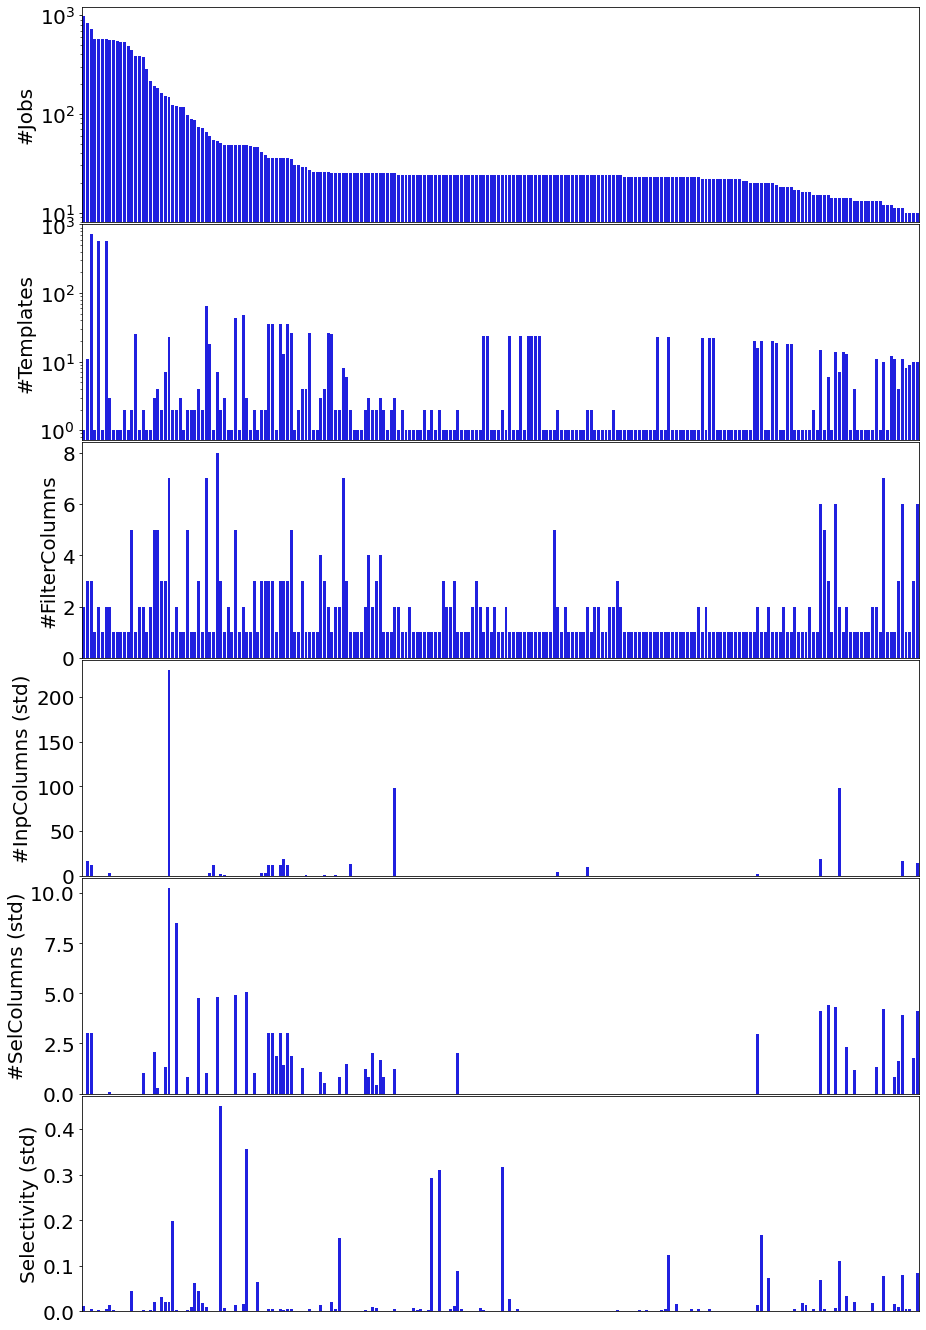

In [681]:
plot_input_stats(inp_stats, FIELDS5, "/Users/pari/Desktop/InputStats-Columns.pdf")

226
16619


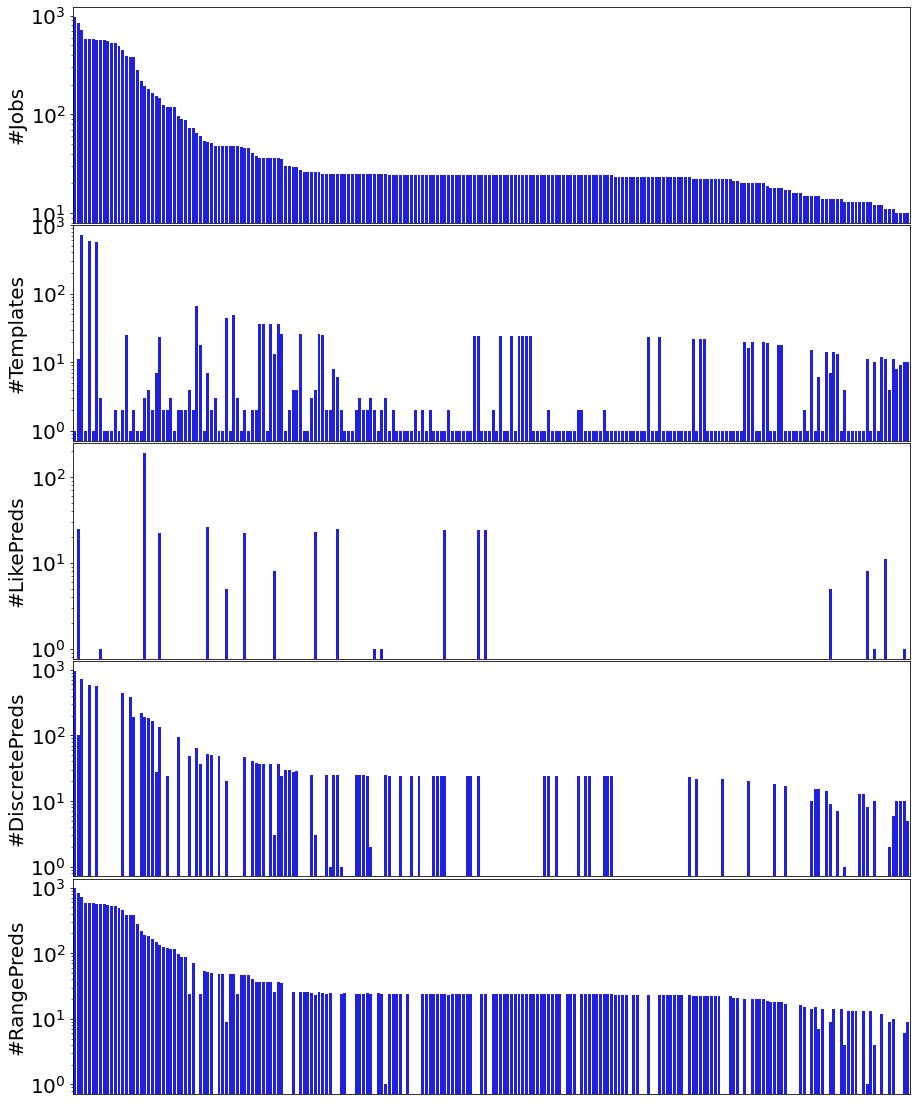

In [683]:
plot_input_stats(inp_stats, FIELDS, "/Users/pari/Desktop/InputStats-FilterKinds.pdf")

90
8108


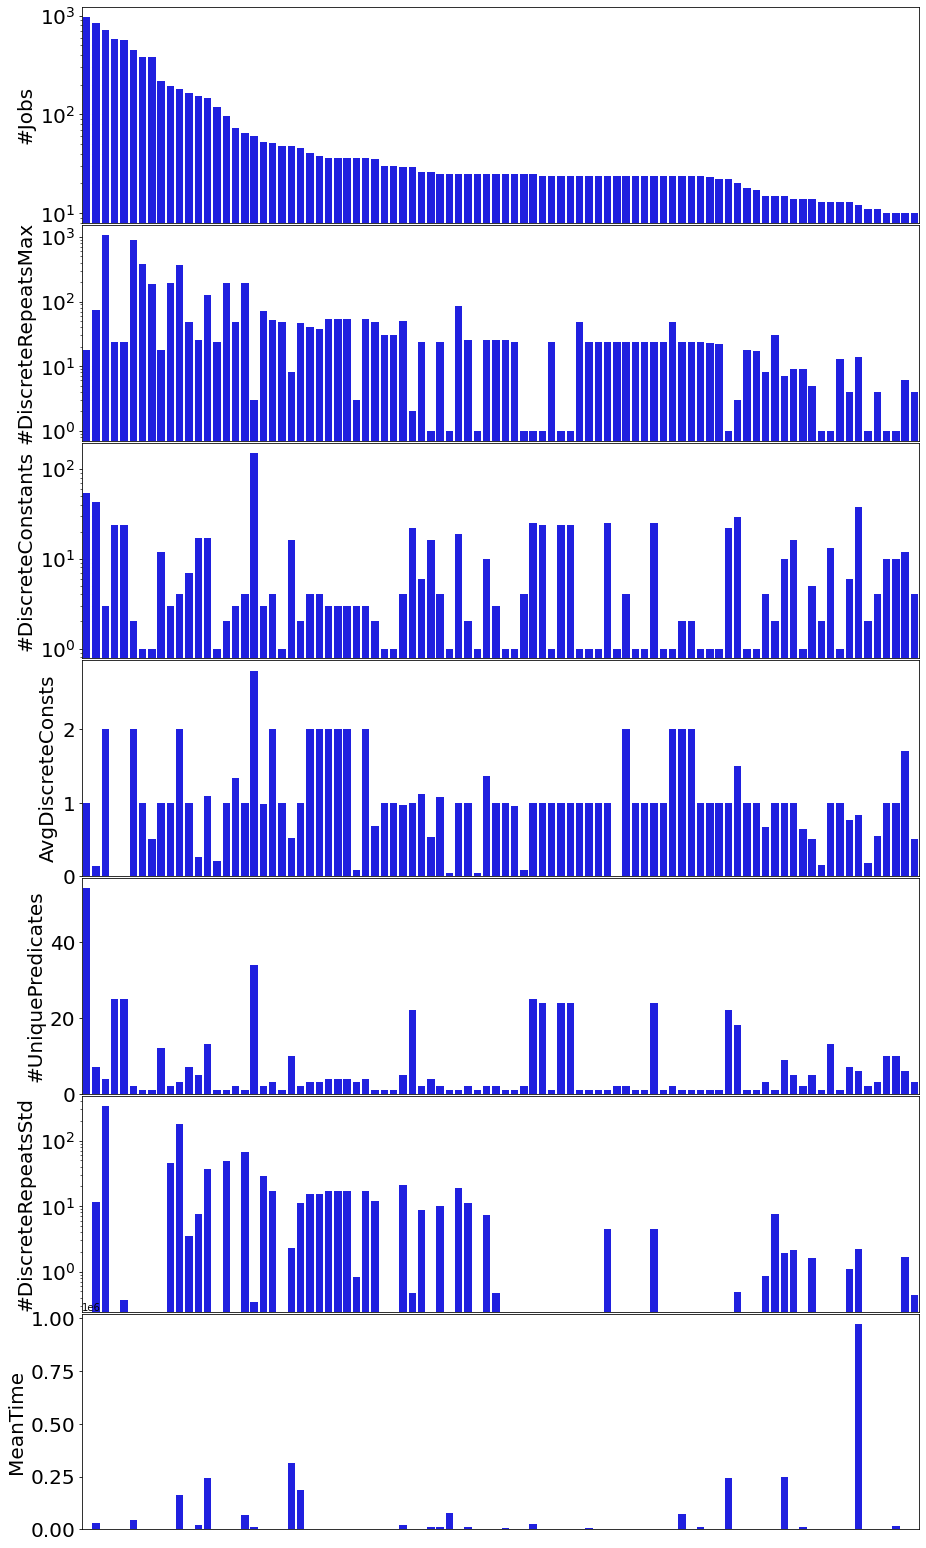

In [686]:
inp_stats2 = inp_stats[inp_stats["#DiscreteConstants"] != 0]
plot_input_stats(inp_stats2, FIELDS2, "/Users/pari/Desktop/InputStats-DiscreteConstants.pdf")

# Most of the repeated discrete values seem to be from shifting continuous values ---> sliding date windows

In [708]:
#inp_stats2.head(1)
for i in range(2):
    val = inp_stats2[INP_FIELD].values[i]
    #print(val)
    print(inp_to_discrete_consts[val])
    dfinp = df[df[INP_FIELD] == val]
    print(dfinp[FILTER_FIELD].values)

{'@"MSXLEADCOMPETITORS"': 18, '@"MSXLEAD"': 18, '@"MSXTERRITORY"': 18, '@"MSXCONSUMPTIONSERVICE"': 18, '@"MSXDYNAMICPROPERTY"': 18, '@"MSXPARTNERACCOUNT"': 18, '@"MSXBUSINESSUNIT"': 18, '@"MSXSALESORDER"': 18, '@"MSXPROCESSSTAGE"': 18, '@"MSXCONSENT"': 18, '@"MSXCAMPAIGN"': 18, '@"MSXLISTMEMBERBATCHES"': 18, '@"MSXLISTMEMBERS"': 18, '@"MSXPRODUCT"': 18, '@"MSXSELLERAPPCONSENT"': 18, '@"MSXTRANSACTIONCURRENCY"': 18, '@"MSXCOMPETITOR"': 18, '@"MSXEMAIL"': 18, '@"MSXSTRINGMAP"': 18, '@"MSXPRICELEVEL"': 18, '@"MSXLICENSINGPROGRAM"': 18, '@"MSXPRODUCTASSOCIATION"': 18, '@"MSXCAMPAIGNACTIVITY"': 18, '@"MSXAPP"': 18, '@"MSXSALESORDERDETAIL"': 18, '@"MSXCONTACT"': 18, '@"MSXACTIVITYPARTY"': 18, '@"MSXFAX"': 18, '@"MSXPHONECALL"': 18, '@"MSXOPPORTUNITYPRODUCT"': 18, '@"MSXTAXONOMYTYPE"': 18, '@"MSXCAMPAIGNRESPONSE"': 18, '@"MSXORDERCLOSE"': 18, '@"MSXAPPOINTMENT"': 18, '@"MSXACCOUNTDEVICEPROFILE"': 18, '@"MSXTAXONOMYTYPEDEPTH"': 18, '@"MSXOPPORTUNITYTEAM"': 18, '@"MSXCONSUMPTIONESTIMATE"': 18, 

In [ ]:
#INPNAME = "adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss"


20
2159


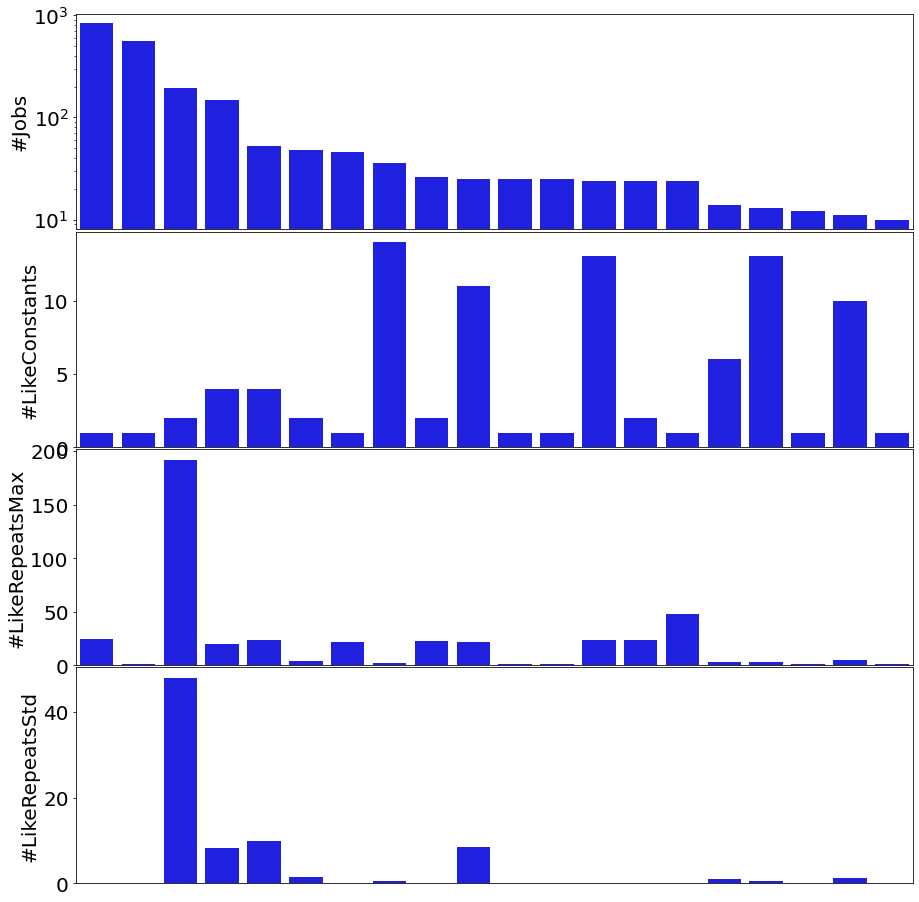

In [687]:
inp_stats3 = inp_stats[inp_stats["#LikeConstants"] != 0]
plot_input_stats(inp_stats3, FIELDS3, "/Users/pari/Desktop/InputStats-LikeConstants.pdf")

NameError: name 'inp_to_discdata' is not defined

226
16619


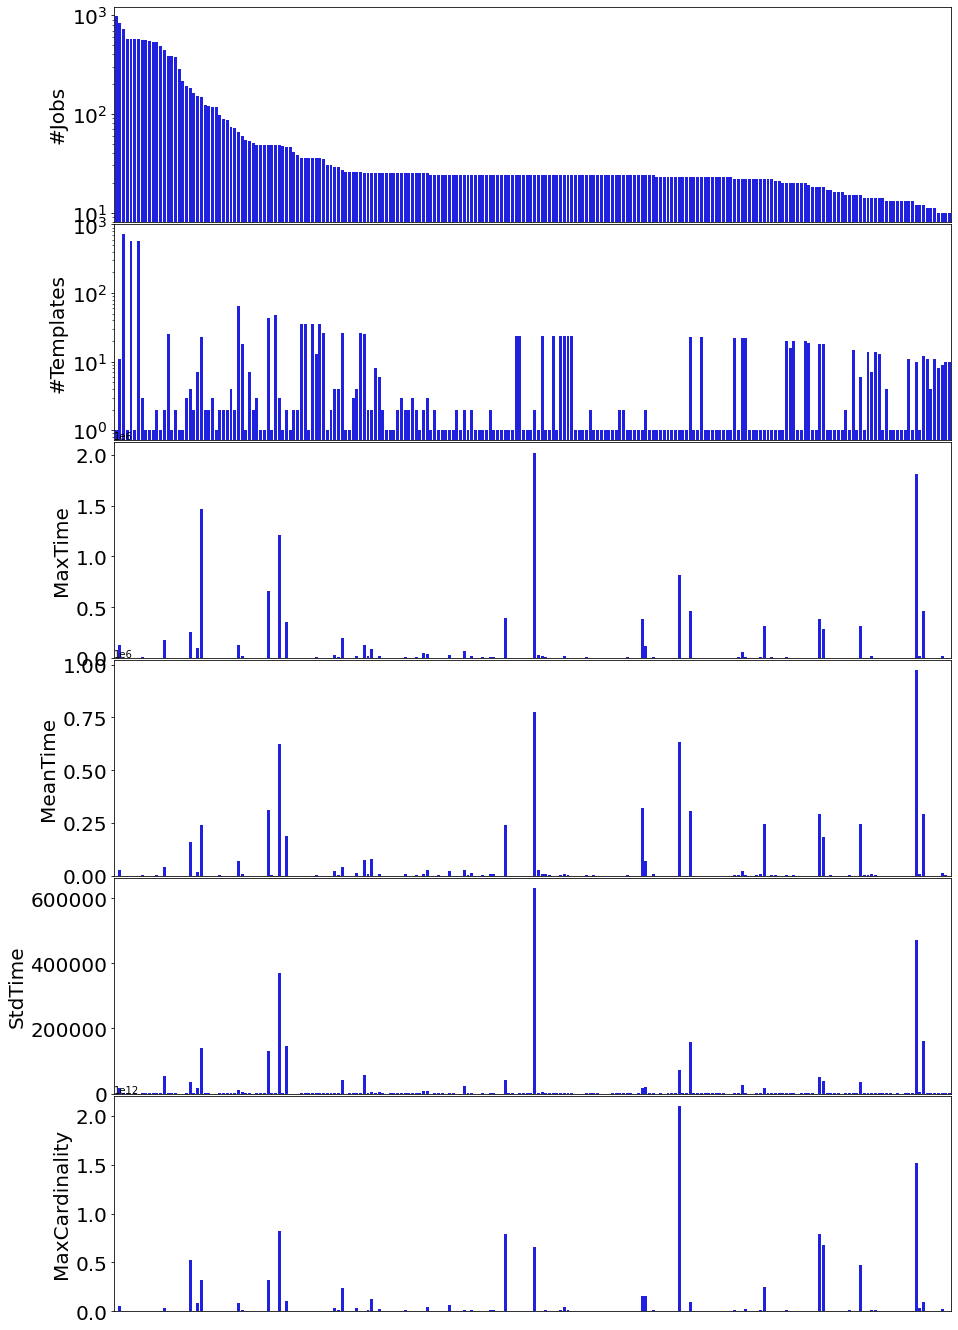

In [690]:
plot_input_stats(inp_stats, FIELDS4, "/Users/pari/Desktop/InputStats-Time.pdf")

# Exploring correlations

In [226]:
inp_stats.keys()

Index(['NormInput', '#Jobs', 'Selectivity (std)', 'Cardinality (std)',
       '#InpColumns (std)', '#SelColumns (std)', '#FilterColumns',
       '#Templates', '#PartitionColumns', 'AvgDiscreteConsts', 'MaxTime',
       'MeanTime', 'StdTime', 'MaxCardinality', '#LikePreds', '#RangePreds',
       '#DiscretePreds', '#UDFPreds', '#InPreds', '#EqualtoDate',
       'AllFilterColumns', 'FilterInPartition', '#DiscreteRepeatsMax',
       '#DiscreteConstants', '#DiscreteRepeatsStd', '#UniquePredicates',
       '#LikeConstants', '#LikeRepeatsMax', '#LikeRepeatsStd'],
      dtype='object')

In [227]:
corr_matrix = inp_stats.corr().abs()
corr_matrix["MaxTime"].reset_index().sort_values(by="MaxTime", ascending=False)

,index,MaxTime
9,MaxTime,1.000000
11,StdTime,0.990607
10,MeanTime,0.946467
1,Selectivity (std),0.462000
12,MaxCardinality,0.263619
2,Cardinality (std),0.240504
6,#Templates,0.208141
19,AllFilterColumns,0.090456
17,#InPreds,0.051782
4,#SelColumns (std),0.050232


# Exploring discrete constants

In [561]:
inp2 = inp_stats.sort_values("#DiscreteConstants", ascending=False)
print(inp2["NormInput"].head(10).values)
inp2.head(100)

<StringArray>
[                                                    'adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Ingestion/MSaaSCase/Staging/Case.ss',
                          'adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss',
                                                      'adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Common/Dimensions/DimApp/VX/DimApp.ss',
 'adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/MDG/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss',
            'adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss',
                                                                   'adl://iebks-proddata-cX.azuredatalakestore.net/local/xblpet/cooked/data/vulcandb/db

,NormInput,#Jobs,Selectivity (std),Cardinality (std),#InpColumns (std),#SelColumns (std),#FilterColumns,#Templates,#PartitionColumns,AvgDiscreteConsts,...,#EqualtoDate,AllFilterColumns,FilterInPartition,#DiscreteRepeatsMax,#DiscreteConstants,#DiscreteRepeatsStd,#UniquePredicates,#LikeConstants,#LikeRepeatsMax,#LikeRepeatsStd
206,adl://supportanalytics-cX.azuredatalakestore.n...,71,0.001113,16697762.262756,2.576789,0.0,1,18,0.0,2.521127,...,0,4,0,5,152,0.574708,34,0,0,0.0
24,adl://jarvis-prod-cX.azuredatalakestore.net/lo...,972,0.011565,295.506982,0.0,0.0,1,1,2.0,1.0,...,0,1,2,18,54,0.000000,54,0,0,0.0
791,adl://asimov-prod-data-cX.azuredatalakestore.n...,10,0.002359,176155032.70555,0.0,2.898275,2,7,1.0,6.0,...,0,3,0,3,47,0.492589,9,0,0,0.0
144,adl://asimov-prod-data-cX.azuredatalakestore.n...,120,0.000268,72927.008781,0.0,11.544288,1,3,3.0,46.0,...,0,1,2,120,46,0.000000,1,0,0,0.0
28,adl://asimov-prod-data-cX.azuredatalakestore.n...,882,0.004416,181374747.589422,15.775453,3.027561,2,19,2.938776,0.401361,...,0,6,1,84,43,13.273183,7,1,36,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,adl://protection-adhoc-cX.azuredatalakestore.n...,19,0.083748,34218.187507,12.296531,4.287886,6,18,2.0,0.842105,...,0,10,0,12,4,0.000000,3,0,0,0.0
695,adl://protection-adhoc-cX.azuredatalakestore.n...,20,0.081991,34950.804865,13.164546,4.536402,6,20,2.0,0.7,...,0,8,0,12,4,1.732051,3,0,0,0.0
317,adl://asimov-prod-data-cX.azuredatalakestore.n...,48,0.028858,6962020.947762,0.0,1.010582,3,2,1.0,1.5,...,0,3,0,48,4,10.392305,3,0,0,0.0
555,adl://asimov-prod-data-cX.azuredatalakestore.n...,24,0.0,682.532879,0.0,0.0,4,1,1.0,2.0,...,0,4,0,24,4,0.000000,2,0,0,0.0


In [566]:
inptmp = inp_stats[inp_stats["#Jobs"] == 4564]
#inptmp = inp_stats[inp_stats["#Jobs"] == 71]
#inptmp = inp_stats[inp_stats["Selectivity (std)"] == 0.001113]

#INPNAME = 'adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Ingestion/MSaaSCase/Staging/Case.ss'
#INPNAME = 'adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss'
#INPNAME = 'adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/MDG/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss'
#inptmp = inp_stats[inp_stats["NormInput"] == INPNAME]

inpid = inptmp["NormInput"].values[0]
print(inpid)
df2 = df[df["NormInput"] == inpid]
print("Num unique jobs: ", len(set(df2["jobid"])))
print("Cols used: ", len(set(df2["unique_filter_cols"])))
print("Cont Ops used: ", set(df2["cont_ops"]))
print("Discrete ops used: ", set(df2["discrete_ops"]))
print("Like ops used: ", set(df2["like_ops"]))
print(df2.keys())
#df2
discdata = inp_to_discrete_consts[inpid]
print(discdata)
print(len(set(df2[FILTER_FIELD])))
print(df2[FILTER_FIELD].values[30])
print(len(set(df2["HashTagNonStrict"])))

adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Processed/BaseModel/Incident/Incident.Unified/Incident.Unified.ss
Num unique jobs:  621
Cols used:  4
Cont Ops used:  {0, 1}
Discrete ops used:  {0, 1}
Like ops used:  {0, 1}
Index(['jobid', 'join', 'inputColumns', 'inputSelected', 'HashTag',
       'HashTagNonStrict', 'HashTagInput', 'HashTagRoot', 'OperatorName',
       'EstCardinality', 'InputCardinality', 'PartitioningColumn',
       'SortColumn', 'NormInput', 'NormInputHashCode', 'FilterExprNorm',
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount',
       'Selectivity', 'num_ops', 'num_unique_ops', 'unique_filter_cols',
       'num_cols_all', 'num_cols_sel', 'num_pcols', 'like_ops', 'discrete_ops',
       'cont_ops', 'udf_ops', 'in_ops', 'equal_dates', 'num_discrete_consts'],
      dtype='object')
{'"MSSolveODS"': 4530, 'null': 3, '"Closed"': 1}
36
{"isComparison":true,"expOperator":"!=","attribute":{"name":"DataSource:26","dataType":"String

# Exploring Like filters

In [ ]:
# for k,v in inp_to_discrete_consts.items():
#     print(k,v)
#     print("**********")

In [ ]:
#plot_input_stats(inp_stats, FIELDS3, "/Users/pari/Desktop/InputStats3-DiffTemplates.pdf")

# Most filters of the kind

In [ ]:
tmp_df = df[df.HashTagInput == 11700902958082612250]
print(tmp_df[FILTER_FIELD].values[0])

In [ ]:
tmp_df = df[df.HashTagInput == 3929217785330710594]
print(tmp_df[FILTER_FIELD].values[1])

In [ ]:
test_attr = tmp_df[FILTER_FIELD].values[1]
d = json.loads(test_attr)
col_names = extract_values(d, "name")
col_names

In [ ]:
test_attr

In [ ]:
len(inp_to_cols[3929217785330710594])

In [ ]:
test = inp_stats[inp_stats["HashTagInput"] == 3929217785330710594]
test

In [ ]:
inp_to_cols[test["HashTagInput"].values[0]]

In [ ]:
type(test["HashTagInput"].values[0])
#test = test.convert_dtypes()

In [ ]:
for idx,row in test.iterrows():
    print(type(row["HashTagInput"]))
    print(int(row["HashTagInput"]))
    print(row["HashTagInput"])

# Exploring columns per input

In [ ]:
df.groupby(["HashTagInput", "inputColumns"]).describe()

# How many sorted columns vs unsorted